In [64]:
#edit this param to process data for one of the following regions: 
# 'lu', 'oz', 'sp'
loc = 'oz'

In [65]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf

import mgwr
import osmnx
osmnx.settings.default_crs = "EPSG:4326"
import requests
import gzip
import shutil
from pathlib import Path
import json
pd.set_option('display.max_columns', 500)

# script file, not a module 

import utils

## Importing audio data & Setting up parameters

In [66]:
gdf = gpd.read_file('..\\output\\distributed_data_s30.GEOJSON', engine='pyogrio', use_arrow=True)
# gdf = gpd.read_file('..\\output\\road_dba_gdf.GEOJSON', engine='pyogrio', use_arrow=True)

In [67]:
#EPSG4326 bounding boxes for science park, oud zuilen, and lunetten
bbox_sp = (52.079691,52.091478,5.160871,5.188251)
bbox_oz = (52.122212,52.132171,5.078688,5.096025)
bbox_lu = (52.057135,52.068401,5.125294,5.143876)

## Combining with OSM street data

In [68]:
# OSM road network parameters
# Note: OSM style guide only indicates unclassified for motor vehicle roads, 
# living_street = erf (<15kmph), highway/trunk = snelweg/autoweg
area_of_interest = 'Utrecht, Netherlands'
car_road_types = ['highway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'living_street', 'busway', 'service']

# Retrieving road network data.
g = osmnx.graph_from_place(area_of_interest)

In [69]:
# * Isolating area: lunetten
if loc == 'lu': lunetten = osmnx.truncate.truncate_graph_bbox(g, bbox=bbox_lu)
if loc == 'oz': lunetten = osmnx.truncate.truncate_graph_bbox(g, bbox=bbox_oz)
if loc == 'sp': lunetten = osmnx.truncate.truncate_graph_bbox(g, bbox=bbox_sp)
node_gdf, edge_gdf = osmnx.graph_to_gdfs(lunetten)
road_gdf = edge_gdf[edge_gdf['maxspeed'].notna() & edge_gdf['highway'].isin(car_road_types)] #todo include the highway = ? ? ? into query instead

for col in road_gdf.columns:
    road_gdf[col] = road_gdf[col].apply(lambda x: x[0] if type(x) == list else x)
    

# Creating dBA_road gdf
road_gdf = road_gdf.to_crs(gdf.crs)
road_dba_gdf = gdf.sjoin_nearest(road_gdf, max_distance=10).drop_duplicates()

# retaining interesting columns for location, noise, and road data
relevant_cols = ['x', 'y', 'geometry', 'median_dBA_raw', 'median_dBA_reg_adj', 'dBA_rivm', 'maxspeed', 'highway', 'bridge', 'junction']
road_dba_gdf = road_dba_gdf[[c for c in relevant_cols if c in road_dba_gdf.columns]]
road_dba_gdf = road_dba_gdf.rename(columns={'median_dBA_raw': 'dBA_raw', 'median_dBA_reg_adj': 'dBA_reg'})

# fixing data types
road_dba_gdf['maxspeed'] = pd.to_numeric(road_dba_gdf['maxspeed'])
if 'junction' in road_dba_gdf.columns:
    road_dba_gdf['junction'] = road_dba_gdf['junction'].apply(lambda x: isinstance(x, str)) # otherwise None
else:
    road_dba_gdf['junction'] = False
road_dba_gdf['bridge'] = road_dba_gdf['bridge'].apply(lambda x: isinstance(x, str)) # otherwise None

# dummy encoding categoricals
for rt in car_road_types:
    column_name = f"rt_{rt}"
    road_dba_gdf[column_name] = road_dba_gdf['highway'] == rt
del road_dba_gdf['highway']


## Adding Location Distances

In [70]:
# dist_to_train

# retrieving train track graph
g = osmnx.graph_from_place(area_of_interest, custom_filter='["railway"]')
train_geoms = osmnx.graph_to_gdfs(g)[1].to_crs(road_dba_gdf.crs).reset_index()['geometry']

# joining to gdf

road_dba_gdf['dist_to_train'] = train_geoms.sindex.nearest(
    road_dba_gdf['geometry'], return_all=False, return_distance=True)[1] # distance index

In [71]:
# retrieving recreation amenity features
amenity_gdf = osmnx.features_from_place(area_of_interest, tags={'amenity': [
               'bar','biergarten','cafe','fast_food','food_court',
               'ice_cream', 'pub', 'restaurant',
               'arts_centre', 'brothel', 'casino', 'cinema', 'community_centre', 
               'conference_centre', 'events_venue', 'exhibition_centre', 
               'gambling', 'love_hotel', 'music_venue', 'nightclub', 'planetarium', 
               'social_centre', 'stage', 'stripclub', 'studio', 'theatre']}
    ) # takes a minute

# joining to gdf
amenity_gdf = amenity_gdf.to_crs(road_dba_gdf.crs)
road_dba_gdf['dist_to_recreation'] = amenity_gdf['geometry'].sindex.nearest(
    road_dba_gdf['geometry'], return_all=False, return_distance=True)[1] # distance index


In [72]:
# * retrieving industrial locations? NVM IT LANDUSE NOW
landuse = osmnx.features_from_place(area_of_interest, tags={'landuse': True}
    ) # takes a minute
landuse = landuse.to_crs(road_dba_gdf.crs)

# adding encoded land use indicators to gdf
road_dba_gdf['landuse_is_residential'] = [dist < 10 for dist in 
        landuse[landuse['landuse'].isin(['residential'])]['geometry'].sindex.nearest(
        road_dba_gdf['geometry'], return_all=False, return_distance=True)[1]]
road_dba_gdf['landuse_is_commercial'] = [dist < 10 for dist in 
        landuse[landuse['landuse'].isin(['commercial', 'retail'])]['geometry'].sindex.nearest(
        road_dba_gdf['geometry'], return_all=False, return_distance=True)[1]]
road_dba_gdf['landuse_is_industrial'] = [dist < 10 for dist in 
        landuse[landuse['landuse'].isin(['industrial'])]['geometry'].sindex.nearest(
        road_dba_gdf['geometry'], return_all=False, return_distance=True)[1]]

## Adding urban height parameter

In [73]:
# Collecting references to relevant height tiles
import shapely
height_tiles = gpd.read_file('..\\data\\height_tile_index.fgb', engine='pyogrio', use_arrow=True)
clip_bbox = road_dba_gdf['geometry'].total_bounds
height_tiles = height_tiles[height_tiles['geometry'].intersects(shapely.box(*clip_bbox))]
height_tiles

,tile_id,cj_sha256,gpkg_sha256,obj_sha256,cj_download,gpkg_download,obj_download,geometry
5881,9/492/584,6113c89c90923e1946f56f3f8971f3167de55ed0acb8da...,48bf4c5ba883a29b994ef80b7c8ad34c23fe20e3d574b0...,46878ce51563730d8693b95f56bf98f129204732839396...,https://data.3dbag.nl/v20240420/tiles/9/492/58...,https://data.3dbag.nl/v20240420/tiles/9/492/58...,https://data.3dbag.nl/v20240420/tiles/9/492/58...,"POLYGON ((136593.338 452890.404, 137593.338 45..."
5883,8/496/584,1a76260b3443ed50a6ef7d25786a6f738b38a218e02b75...,4ba2e499f01805d9cf2f352c738430e2bb9da0e78fb0f3...,12dc255c0cd42474f629ee45ba17e1cbdbd2d7e262ed3b...,https://data.3dbag.nl/v20240420/tiles/8/496/58...,https://data.3dbag.nl/v20240420/tiles/8/496/58...,https://data.3dbag.nl/v20240420/tiles/8/496/58...,"POLYGON ((137593.338 452890.404, 139593.338 45..."
5904,8/488/576,45e8c65101df6b5a2a26e39e2fdc8e393783c4ff5e625f...,06ce83370723d8013e5466abc993efd757b4192717af17...,78e18ebad028e6760d15afa15603e24f6e369ae818d862...,https://data.3dbag.nl/v20240420/tiles/8/488/57...,https://data.3dbag.nl/v20240420/tiles/8/488/57...,https://data.3dbag.nl/v20240420/tiles/8/488/57...,"POLYGON ((135593.338 450890.404, 137593.338 45..."
5905,8/496/576,9d870bf286c8b3489c62478fc1c5e177eeee0313d3e277...,67c99ad2ec41777d4f2bbb9ac8e2f61dcea8ebe0b46753...,478aeb49a7050f78617ebca8f03f8dd4c738111a10792c...,https://data.3dbag.nl/v20240420/tiles/8/496/57...,https://data.3dbag.nl/v20240420/tiles/8/496/57...,https://data.3dbag.nl/v20240420/tiles/8/496/57...,"POLYGON ((137593.338 450890.404, 139593.338 45..."


In [74]:
# Downloading relevant height tiles and combining into singular gdf

def download_and_extract_gpkg(url, output_path):
    output_path = Path(output_path)
    # Download the file
    response = requests.get(url, stream=True)
    compressed_file_path = output_path.with_suffix('.gz')

    # Save the gzipped file
    with open(compressed_file_path, 'wb') as f:
        f.write(response.content)

    # Decompress the file
    with gzip.open(compressed_file_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Clean up the compressed file
    compressed_file_path.unlink()

height_gdf = None
for url in height_tiles['gpkg_download']:
    print(url)
    file_name = url.split('/')[-1][:-3]
    file_location= f'..\\data\\height_squares\\{file_name}'
    if not os.path.isfile(file_location):
        download_and_extract_gpkg(url, file_location)
    
    # # Load the JSON data
    # with open(file_location, 'r', encoding='utf-8') as f:
    #     json_data = json.load(f)

    # # Convert JSON data to GeoDataFrame
    # gdf = gpd.GeoDataFrame.from_features(json_data['b3_h_dak_70p', 'geometry'])

    
    gdf = gpd.read_file(file_location)
    if not isinstance(gdf, pd.DataFrame): height_gdf = gdf; continue
    height_gdf = pd.concat((height_gdf, gdf))

building_df = None
for url in height_tiles['cj_download']:
    print(url)
    file_name = url.split('/')[-1][:-3]
    file_location= f'..\\data\\height_squares\\{file_name}'
    if not os.path.isfile(file_location):
        download_and_extract_gpkg(url, file_location)
    
    # Load the JSON data
    with open(file_location, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    # extract building height and id's from json data
    h_70p = [json_data['CityObjects'][building_obj]['attributes']['b3_h_dak_70p'] 
         for building_obj in json_data['CityObjects'].keys()
         if 'b3_h_dak_min' in json_data['CityObjects'][building_obj]['attributes'].keys()]
    h_id = [building_obj
            for building_obj in json_data['CityObjects'].keys()
            if 'b3_h_dak_min' in json_data['CityObjects'][building_obj]['attributes'].keys()]
    # combining extracted data into singular df
    df = pd.DataFrame({'identificatie': h_id, 'height_70p': h_70p})
    if not isinstance(df, pd.DataFrame): building_df = df; continue
    building_df = pd.concat((building_df, df))
# combining building geometries with building heights
height_gdf = height_gdf.merge(building_df, on='identificatie', how='left')
del building_df, h_70p, h_id, df, gdf    

https://data.3dbag.nl/v20240420/tiles/9/492/584/9-492-584.gpkg.gz
https://data.3dbag.nl/v20240420/tiles/8/496/584/8-496-584.gpkg.gz
https://data.3dbag.nl/v20240420/tiles/8/488/576/8-488-576.gpkg.gz
https://data.3dbag.nl/v20240420/tiles/8/496/576/8-496-576.gpkg.gz
https://data.3dbag.nl/v20240420/tiles/9/492/584/9-492-584.city.json.gz
https://data.3dbag.nl/v20240420/tiles/8/496/584/8-496-584.city.json.gz
https://data.3dbag.nl/v20240420/tiles/8/488/576/8-488-576.city.json.gz
https://data.3dbag.nl/v20240420/tiles/8/496/576/8-496-576.city.json.gz


In [75]:
# Connecting height_gdf to road dba data

# then collect each building which intersects said buffer
# retain heighest building height in that buffer
def get_building_for_road(road_gdf, building_heights, buffer_radius=25, height_col='height_70p'): # for each point in road_dba_gdf
    # this gon be very expensive
    road_points = road_gdf['geometry'].buffer(buffer_radius) # create a buffer of 15(?)m
    return [building_heights[building_heights['geometry'].intersects(rp)][height_col].max() 
            for rp in road_points]

road_dba_gdf['building_height'] = get_building_for_road(road_dba_gdf, height_gdf)
# fill nans with building height zero
road_dba_gdf['building_height'] = road_dba_gdf['building_height'].fillna(0)




## Saving

In [76]:
road_dba_gdf.to_file(f'..\\output\\data_{loc}_s30.GEOJSON')

## Experiments

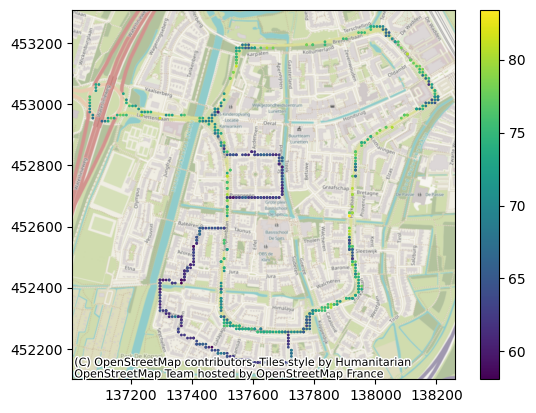

In [77]:
ax = road_dba_gdf.plot(column='dBA_reg', markersize=1, legend=True)
cx.add_basemap(ax, crs=road_dba_gdf.crs)

In [78]:
road_dba_gdf

,x,y,geometry,dBA_raw,dBA_reg,dBA_rivm,maxspeed,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,dist_to_train,dist_to_recreation,landuse_is_residential,landuse_is_commercial,landuse_is_industrial,building_height
1075419,137035.0,453375.0,POINT (137035.000 453375.000),NaN,NaN,54,30,False,False,False,False,False,False,False,False,True,False,False,False,874.508813,162.732958,True,False,False,11.19
1075419,137035.0,453375.0,POINT (137035.000 453375.000),NaN,NaN,54,30,False,False,False,False,False,False,False,False,True,False,False,False,874.508813,162.732958,True,False,False,11.19
1075420,137045.0,453375.0,POINT (137045.000 453375.000),NaN,NaN,54,30,False,False,False,False,False,False,False,False,True,False,False,False,868.745335,158.597061,True,False,False,11.19
1075421,137055.0,453375.0,POINT (137055.000 453375.000),NaN,NaN,54,30,False,False,False,False,False,False,False,False,True,False,False,False,862.663316,154.996903,True,False,False,11.19
1075422,137065.0,453375.0,POINT (137065.000 453375.000),NaN,NaN,54,30,False,False,False,False,False,False,False,False,True,False,False,False,856.267682,151.970563,True,False,False,11.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237808,137765.0,452135.0,POINT (137765.000 452135.000),NaN,NaN,54,15,False,False,False,False,False,False,False,False,False,True,False,False,1436.106794,142.681676,True,False,False,12.34
1237809,137775.0,452135.0,POINT (137775.000 452135.000),NaN,NaN,53,15,False,False,False,False,False,False,False,False,False,True,False,False,1432.095512,133.018436,True,False,False,12.34
1237809,137775.0,452135.0,POINT (137775.000 452135.000),NaN,NaN,53,15,False,False,False,False,False,False,False,False,False,True,False,False,1432.095512,133.018436,True,False,False,12.34
1237809,137775.0,452135.0,POINT (137775.000 452135.000),NaN,NaN,53,15,False,False,False,False,False,False,False,False,False,True,False,False,1432.095512,133.018436,True,False,False,12.34
